# Müşteri Taleplerinin Detaylı Analizi

Bu notebook, 40 gerçek müşteri sohbetinden elde edilen intent verilerini analiz ederek müşterilerin en çok hangi konularda destek istediğini çıkarır.

**Veri Kaynağı:** intent_analysis_results_40_chats.csv  
**Analiz Tarihi:** Eylül 2025  
**Model:** OpenAI GPT-5-nano (%95 doğruluk)


## 1. Gerekli Kütüphaneler ve Veri Yükleme


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

print("✅ Kütüphaneler yüklendi!")
print("📊 Müşteri talepleri analizi başlıyor...")


✅ Kütüphaneler yüklendi!
📊 Müşteri talepleri analizi başlıyor...


In [2]:
# Veriyi yükle
df = pd.read_csv('intent_analysis_results_40_chats.csv')

print(f"📋 Toplam sohbet sayısı: {len(df)}")
print(f"📊 Veri boyutları: {df.shape}")
print(f"✅ Başarılı analiz sayısı: {df['is_correct'].sum()}")
print(f"🎯 Doğruluk oranı: %{(df['is_correct'].sum() / len(df) * 100):.1f}")

# İlk 5 satırı göster
print("\n📝 Veri önizlemesi:")
df[['chat_id', 'ground_truth_intent', 'ground_truth_detail', 'ground_truth_tur']].head()


📋 Toplam sohbet sayısı: 40
📊 Veri boyutları: (40, 10)
✅ Başarılı analiz sayısı: 38
🎯 Doğruluk oranı: %95.0

📝 Veri önizlemesi:


,chat_id,ground_truth_intent,ground_truth_detail,ground_truth_tur
0,90001,Eksik ürün,Sipariş teslimatında eksik ürün,Şikayet
1,90002,Şifre sıfırlama,E-posta linki gelmemesi,Sorun
2,90003,İade,İade prosedürü hakkında bilgi,Bilgi alma
3,90004,Kupon,Kupon kodunun çalışmaması,Sorun
4,90005,İptal,Sipariş iptali,İstek


## 2. Intent Kategorileri Analizi


In [3]:
# Intent kategorilerini analiz et
intent_counts = df['ground_truth_intent'].value_counts()
intent_percentages = (intent_counts / len(df) * 100).round(1)

print("🏆 EN ÇOK KARŞILAŞILAN MÜŞTERİ TALEPLERİ:")
print("=" * 60)

for i, (intent, count) in enumerate(intent_counts.head(10).items(), 1):
    percentage = intent_percentages[intent]
    print(f"{i:2}. {intent:<20} : {count:2} sohbet ({percentage:4.1f}%)")

print(f"\n📊 Toplam farklı intent kategorisi: {len(intent_counts)}")
print(f"🔝 İlk 5 kategori toplam payı: %{intent_percentages.head(5).sum():.1f}")


🏆 EN ÇOK KARŞILAŞILAN MÜŞTERİ TALEPLERİ:
 1. İade                 :  5 sohbet (12.5%)
 2. Ödeme                :  4 sohbet (10.0%)
 3. Eksik ürün           :  3 sohbet ( 7.5%)
 4. Kargo                :  3 sohbet ( 7.5%)
 5. İptal                :  3 sohbet ( 7.5%)
 6. Adres hatası         :  2 sohbet ( 5.0%)
 7. Kupon                :  2 sohbet ( 5.0%)
 8. Hesap bilgisi        :  1 sohbet ( 2.5%)
 9. Hasarlı ürün         :  1 sohbet ( 2.5%)
10. Teknik sorun         :  1 sohbet ( 2.5%)

📊 Toplam farklı intent kategorisi: 25
🔝 İlk 5 kategori toplam payı: %45.0


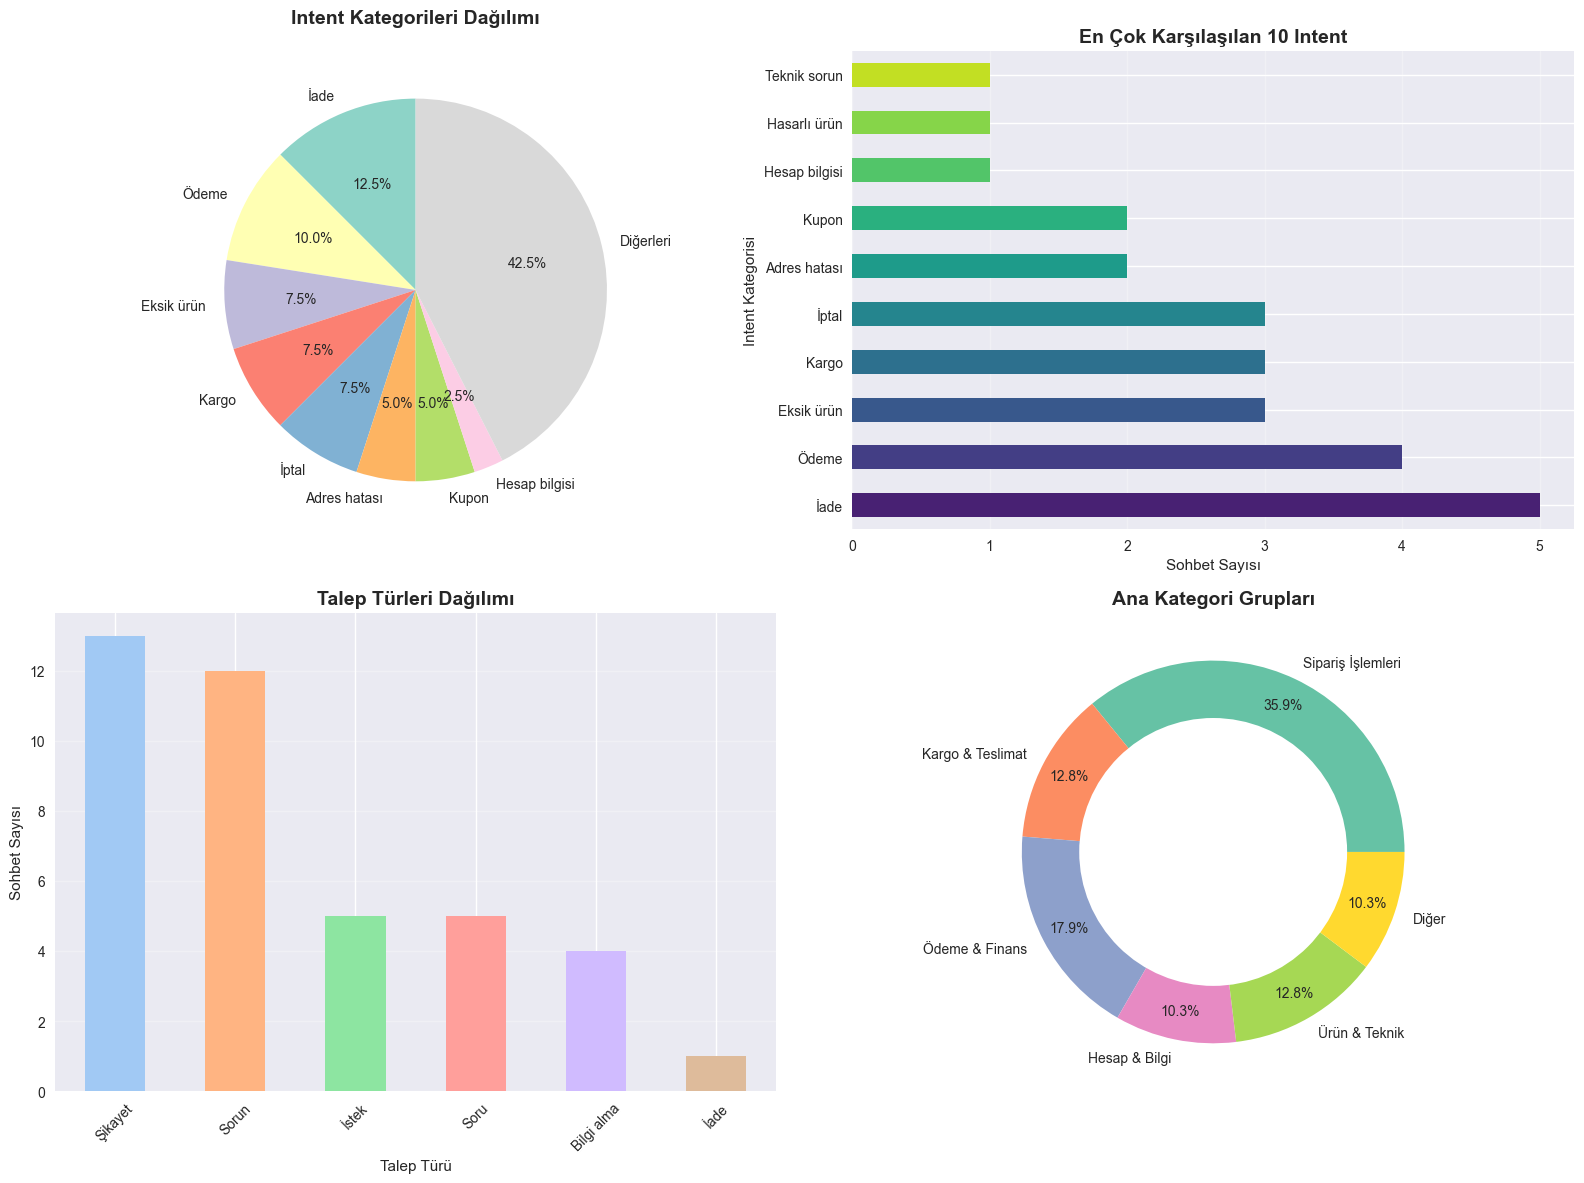

In [4]:
# Intent dağılımı görselleştirme
plt.figure(figsize=(16, 12))

# 1. Pasta grafik - En çok karşılaşılan intentler
plt.subplot(2, 2, 1)
top_8 = intent_counts.head(8)
others = intent_counts.iloc[8:].sum()

if others > 0:
    plot_data = pd.concat([top_8, pd.Series({'Diğerleri': others})])
else:
    plot_data = top_8

colors = sns.color_palette("Set3", len(plot_data))
wedges, texts, autotexts = plt.pie(plot_data.values, 
                                   labels=plot_data.index,
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90,
                                   textprops={'fontsize': 10})
plt.title('Intent Kategorileri Dağılımı', fontsize=14, fontweight='bold', pad=20)

# 2. Bar grafik - En çok karşılaşılan 10 intent
plt.subplot(2, 2, 2)
intent_counts.head(10).plot(kind='barh', color=sns.color_palette("viridis", 10))
plt.title('En Çok Karşılaşılan 10 Intent', fontsize=14, fontweight='bold')
plt.xlabel('Sohbet Sayısı')
plt.ylabel('Intent Kategorisi')
plt.grid(axis='x', alpha=0.3)

# 3. Talep türleri dağılımı
plt.subplot(2, 2, 3)
tur_counts = df['ground_truth_tur'].value_counts()
tur_counts.plot(kind='bar', color=sns.color_palette("pastel", len(tur_counts)))
plt.title('Talep Türleri Dağılımı', fontsize=14, fontweight='bold')
plt.xlabel('Talep Türü')
plt.ylabel('Sohbet Sayısı')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# 4. Ana kategoriler donut chart
plt.subplot(2, 2, 4)
main_categories = {
    'Sipariş İşlemleri': ['İade', 'İptal', 'Eksik ürün', 'Yanlış ürün', 'Hasarlı ürün', 'Defolu ürün'],
    'Kargo & Teslimat': ['Kargo', 'Adres hatası'],
    'Ödeme & Finans': ['Ödeme', 'Kupon', 'Fatura hatası'],
    'Hesap & Bilgi': ['Hesap bilgisi', 'Hesap kapatma', 'Şifre sıfırlama', 'Abonelik'],
    'Ürün & Teknik': ['Ürün', 'Beden tablosu', 'Beden', 'Teknik sorun', 'Web sitesi'],
    'Diğer': ['İndirim', 'Stok', 'Yorum', 'Değişim']
}

category_counts = {}
for main_cat, sub_cats in main_categories.items():
    count = df[df['ground_truth_intent'].isin(sub_cats)]['ground_truth_intent'].count()
    if count > 0:
        category_counts[main_cat] = count

plt.pie(category_counts.values(), 
        labels=category_counts.keys(),
        autopct='%1.1f%%',
        colors=sns.color_palette("Set2", len(category_counts)),
        pctdistance=0.85,
        textprops={'fontsize': 10})

# Donut efekti
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Ana Kategori Grupları', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


## 3. Detaylı İstatistiksel Analiz


In [5]:
# İstatistiksel özet raporu
print("📈 DETAYLI İSTATİSTİKSEL ANALİZ")
print("=" * 80)

# 1. En çok karşılaşılan intentler
print("\n🥇 TOP 5 MÜŞTERİ TALEPLERİ:")
print("-" * 50)
top_5_intents = intent_counts.head(5)
total_top_5 = top_5_intents.sum()

for i, (intent, count) in enumerate(top_5_intents.items(), 1):
    percentage = (count / len(df)) * 100
    percentage_in_top5 = (count / total_top_5) * 100
    print(f"{i}. {intent:<18}: {count:2} sohbet ({percentage:5.1f}% | Top5 içinde %{percentage_in_top5:4.1f})")

print(f"\n📊 Top 5 toplam payı: {total_top_5}/{len(df)} = %{(total_top_5/len(df)*100):.1f}")

# 2. Talep türleri analizi
print("\n🎯 TALEP TÜRLERİ ANALİZİ:")
print("-" * 50)
tur_analysis = df['ground_truth_tur'].value_counts()
for tur, count in tur_analysis.items():
    percentage = (count / len(df)) * 100
    print(f"• {tur:<15}: {count:2} sohbet ({percentage:5.1f}%)")

# 3. Intent-Tür çapraz analizi
print("\n🔍 INTENT-TÜR ÇAPRAZ ANALİZİ:")
print("-" * 50)
cross_tab = pd.crosstab(df['ground_truth_intent'], df['ground_truth_tur'], margins=True)
print(cross_tab.head(10))


📈 DETAYLI İSTATİSTİKSEL ANALİZ

🥇 TOP 5 MÜŞTERİ TALEPLERİ:
--------------------------------------------------
1. İade              :  5 sohbet ( 12.5% | Top5 içinde %27.8)
2. Ödeme             :  4 sohbet ( 10.0% | Top5 içinde %22.2)
3. Eksik ürün        :  3 sohbet (  7.5% | Top5 içinde %16.7)
4. Kargo             :  3 sohbet (  7.5% | Top5 içinde %16.7)
5. İptal             :  3 sohbet (  7.5% | Top5 içinde %16.7)

📊 Top 5 toplam payı: 18/40 = %45.0

🎯 TALEP TÜRLERİ ANALİZİ:
--------------------------------------------------
• Şikayet        : 13 sohbet ( 32.5%)
• Sorun          : 12 sohbet ( 30.0%)
• İstek          :  5 sohbet ( 12.5%)
• Soru           :  5 sohbet ( 12.5%)
• Bilgi alma     :  4 sohbet ( 10.0%)
• İade           :  1 sohbet (  2.5%)

🔍 INTENT-TÜR ÇAPRAZ ANALİZİ:
--------------------------------------------------
ground_truth_tur     Bilgi alma  Soru  Sorun  İade  İstek  Şikayet  All
ground_truth_intent                                                    
Abonelik      

In [6]:
# Özet rapor ve sonuçları kaydetme
print("📋 MÜŞTERİ TALEPLERİ ANALİZ RAPORU - ÖZET")
print("=" * 80)

# Temel istatistikler
total_chats = len(df)
unique_intents = len(intent_counts)
top_5_share = (intent_counts.head(5).sum() / total_chats) * 100

print(f"\n📊 TEMEL İSTATİSTİKLER:")
print(f"   • Toplam sohbet sayısı: {total_chats}")
print(f"   • Farklı intent kategorisi: {unique_intents}")
print(f"   • En çok karşılaşılan 5 kategori payı: %{top_5_share:.1f}")

print(f"\n🏆 EN ÇOK KARŞILAŞILAN TALEPLER:")
for i, (intent, count) in enumerate(intent_counts.head(5).items(), 1):
    percentage = (count / total_chats) * 100
    print(f"   {i}. {intent}: {count} sohbet (%{percentage:.1f})")

print(f"\n📈 TALEP TÜRLERİ DAĞILIMI:")
for tur, count in df['ground_truth_tur'].value_counts().items():
    percentage = (count / total_chats) * 100
    print(f"   • {tur}: {count} sohbet (%{percentage:.1f})")

# Ana kategori özetleri
print(f"\n🎯 ANA KATEGORİ ÖZETLERİ:")
main_cat_summary = {}
for main_cat, sub_cats in main_categories.items():
    count = df[df['ground_truth_intent'].isin(sub_cats)]['ground_truth_intent'].count()
    if count > 0:
        percentage = (count / total_chats) * 100
        main_cat_summary[main_cat] = (count, percentage)

for cat, (count, pct) in sorted(main_cat_summary.items(), key=lambda x: x[1][0], reverse=True):
    print(f"   • {cat}: {count} sohbet (%{pct:.1f})")

# CSV kaydetme
intent_summary = pd.DataFrame({
    'Intent': intent_counts.index,
    'Sohbet_Sayisi': intent_counts.values,
    'Yuzde': intent_percentages.values
})

intent_summary.to_csv('musteri_talepleri_ozet.csv', index=False, encoding='utf-8')

print(f"\n💾 Analiz sonuçları 'musteri_talepleri_ozet.csv' dosyasına kaydedildi.")
print(f"\n✅ ANALIZ TAMAMLANDI!")
print(f"📅 Rapor tarihi: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")

# En önemli bulgular
print(f"\n🎯 ÖNEMLİ BULGULAR:")
print(f"   1. En çok talep: {intent_counts.index[0]} (%{intent_percentages.iloc[0]:.1f})")
print(f"   2. En sık talep türü: {tur_analysis.index[0]} (%{(tur_analysis.iloc[0]/total_chats*100):.1f})")
print(f"   3. Sipariş işlemleri toplam payı: %{main_cat_summary.get('Sipariş İşlemleri', (0,0))[1]:.1f}")

intent_summary.head(10)


📋 MÜŞTERİ TALEPLERİ ANALİZ RAPORU - ÖZET

📊 TEMEL İSTATİSTİKLER:
   • Toplam sohbet sayısı: 40
   • Farklı intent kategorisi: 25
   • En çok karşılaşılan 5 kategori payı: %45.0

🏆 EN ÇOK KARŞILAŞILAN TALEPLER:
   1. İade: 5 sohbet (%12.5)
   2. Ödeme: 4 sohbet (%10.0)
   3. Eksik ürün: 3 sohbet (%7.5)
   4. Kargo: 3 sohbet (%7.5)
   5. İptal: 3 sohbet (%7.5)

📈 TALEP TÜRLERİ DAĞILIMI:
   • Şikayet: 13 sohbet (%32.5)
   • Sorun: 12 sohbet (%30.0)
   • İstek: 5 sohbet (%12.5)
   • Soru: 5 sohbet (%12.5)
   • Bilgi alma: 4 sohbet (%10.0)
   • İade: 1 sohbet (%2.5)

🎯 ANA KATEGORİ ÖZETLERİ:
   • Sipariş İşlemleri: 14 sohbet (%35.0)
   • Ödeme & Finans: 7 sohbet (%17.5)
   • Kargo & Teslimat: 5 sohbet (%12.5)
   • Ürün & Teknik: 5 sohbet (%12.5)
   • Hesap & Bilgi: 4 sohbet (%10.0)
   • Diğer: 4 sohbet (%10.0)

💾 Analiz sonuçları 'musteri_talepleri_ozet.csv' dosyasına kaydedildi.

✅ ANALIZ TAMAMLANDI!
📅 Rapor tarihi: 2025-09-17 16:56

🎯 ÖNEMLİ BULGULAR:
   1. En çok talep: İade (%12.5)
   2

,Intent,Sohbet_Sayisi,Yuzde
0,İade,5,12.5
1,Ödeme,4,10.0
2,Eksik ürün,3,7.5
3,Kargo,3,7.5
4,İptal,3,7.5
5,Adres hatası,2,5.0
6,Kupon,2,5.0
7,Hesap bilgisi,1,2.5
8,Hasarlı ürün,1,2.5
9,Teknik sorun,1,2.5
